In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(digest)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
set.seed(7493)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Here we are reading the data. From a URL and changing the values of the AwayTeam and HomeTeam as factors to create distinct teams. Next, the results to be predicted, FTHG and FTAG are also changed to integer values instead of decimals because the number of goals scored in a soccer game is always an integer value. FTHG = full time home goals. FTAG = full time away goals. We also change FTR (full time results) to factors so the data can be split evenly. FTR is also a value to be predicted.

In [6]:
url <- "https://raw.githubusercontent.com/armanmoztar/group-project/main/data/season_2018.csv"

match_data <- read_csv(url) %>%    #reading the csv from url
            mutate(FTR = as_factor(FTR),       # mutate changes the data in the types we want
                  AwayTeam = as_factor(AwayTeam),
                  FTHG = as.integer(FTHG),
                  FTAG = as.integer(FTAG),
                  HomeTeam = as_factor(HomeTeam))

match_data 

Parsed with column specification:
cols(
  .default = col_double(),
  Div = col_character(),
  Date = col_character(),
  HomeTeam = col_character(),
  AwayTeam = col_character(),
  FTR = col_character(),
  HTR = col_character(),
  Referee = col_character()
)

See spec(...) for full column specifications.



Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,⋯,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
<chr>,<chr>,<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,⋯,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,⋯,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,⋯,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
E0,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,⋯,2.29,22,-1.5,2.27,2.16,1.80,1.73,1.37,5.36,8.49
E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,⋯,2.07,19,-0.5,2.13,2.08,1.85,1.80,1.91,3.81,4.15
E0,12/05/2019,Watford,West Ham,1,4,A,0,2,A,⋯,2.44,19,-0.5,2.25,2.19,1.78,1.72,2.11,3.86,3.41


Below we create an initial split of data to seperate the training and testing data. We are using a porportion of 75% training data and 25% testing data. The strata is set to FTR (full time results), to get an even split of games where the home team wins and where the home team loses. 

In [8]:
match_split <- initial_split(match_data, prop = 3/4, strata = "FTR")   #creating the initial split with the parameters described above
match_train <- training(match_split)   #the training data
match_test <- testing(match_split)     #the testing data


This is just a simple visualization to demonstrate what our data represents. Below represents the number of matches won by each home team. We are using the group by and summary functions to see which teams have won the most amount of games and home and the most amount of games away. Note: This visualization is not essential to the regression but demonstrates how the results of our data can be used to create predictions for tables of this sort. Being able to make predictions like this table can guide a person's betting decisions.  

In [10]:
training_summary_netscore <- match_train %>%   
                group_by(FTR, HomeTeam, AwayTeam, FTHG, FTAG) %>%
                summarize() %>% 
                mutate(Net_Score = FTHG - FTAG)  #this subtracts the full time home team goals from the full time away team goals. 
                                                # this value (NetScore) represents which team wins the game and by how much. For example
                                                # if the value is 0, then the game ends in a draw, if the value is positive, then the home team
                                                # scored more goals, meaning that the home team won and if the value is negative, then the away
                                                # team won by the amount given as NetScore. 

training_summary_nwin_home <- match_train %>% 
                group_by(FTR, HomeTeam) %>%
                summarize(TotalWinsHome = n()) %>% 
                arrange(desc(TotalWinsHome))  #arranging by descending number of wins

training_summary_nwin_away <- match_train %>% 
                group_by(FTR, AwayTeam) %>%
                summarize(TotalWinsAway = n()) %>% 
                arrange(desc(TotalWinsAway))  #arranging by descending number of wins

training_summary_netscore
training_summary_nwin_home
training_summary_nwin_away

`summarise()` regrouping output by 'FTR', 'HomeTeam', 'AwayTeam', 'FTHG' (override with `.groups` argument)

`summarise()` regrouping output by 'FTR' (override with `.groups` argument)

`summarise()` regrouping output by 'FTR' (override with `.groups` argument)



FTR,HomeTeam,AwayTeam,FTHG,FTAG,Net_Score
<fct>,<fct>,<fct>,<int>,<int>,<int>
H,Man United,Leicester,2,1,1
H,Man United,Everton,2,1,1
H,Man United,West Ham,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮
D,Crystal Palace,Everton,0,0,0
D,Crystal Palace,West Ham,1,1,0
D,Crystal Palace,Newcastle,0,0,0


FTR,HomeTeam,TotalWinsHome
<fct>,<fct>,<int>
H,Man City,17
H,Liverpool,14
A,Huddersfield,12
⋮,⋮,⋮
D,Newcastle,1
D,Liverpool,1
D,Burnley,1


FTR,AwayTeam,TotalWinsAway
<fct>,<fct>,<int>
H,Fulham,12
H,Huddersfield,12
A,Liverpool,11
⋮,⋮,⋮
H,Liverpool,1
A,Fulham,1
A,Huddersfield,1


In [ ]:
We plan on using a regression model to predict the value of netscore, which will be able to give us our intended results, which are which team wins the game, and by how much.
The below visua

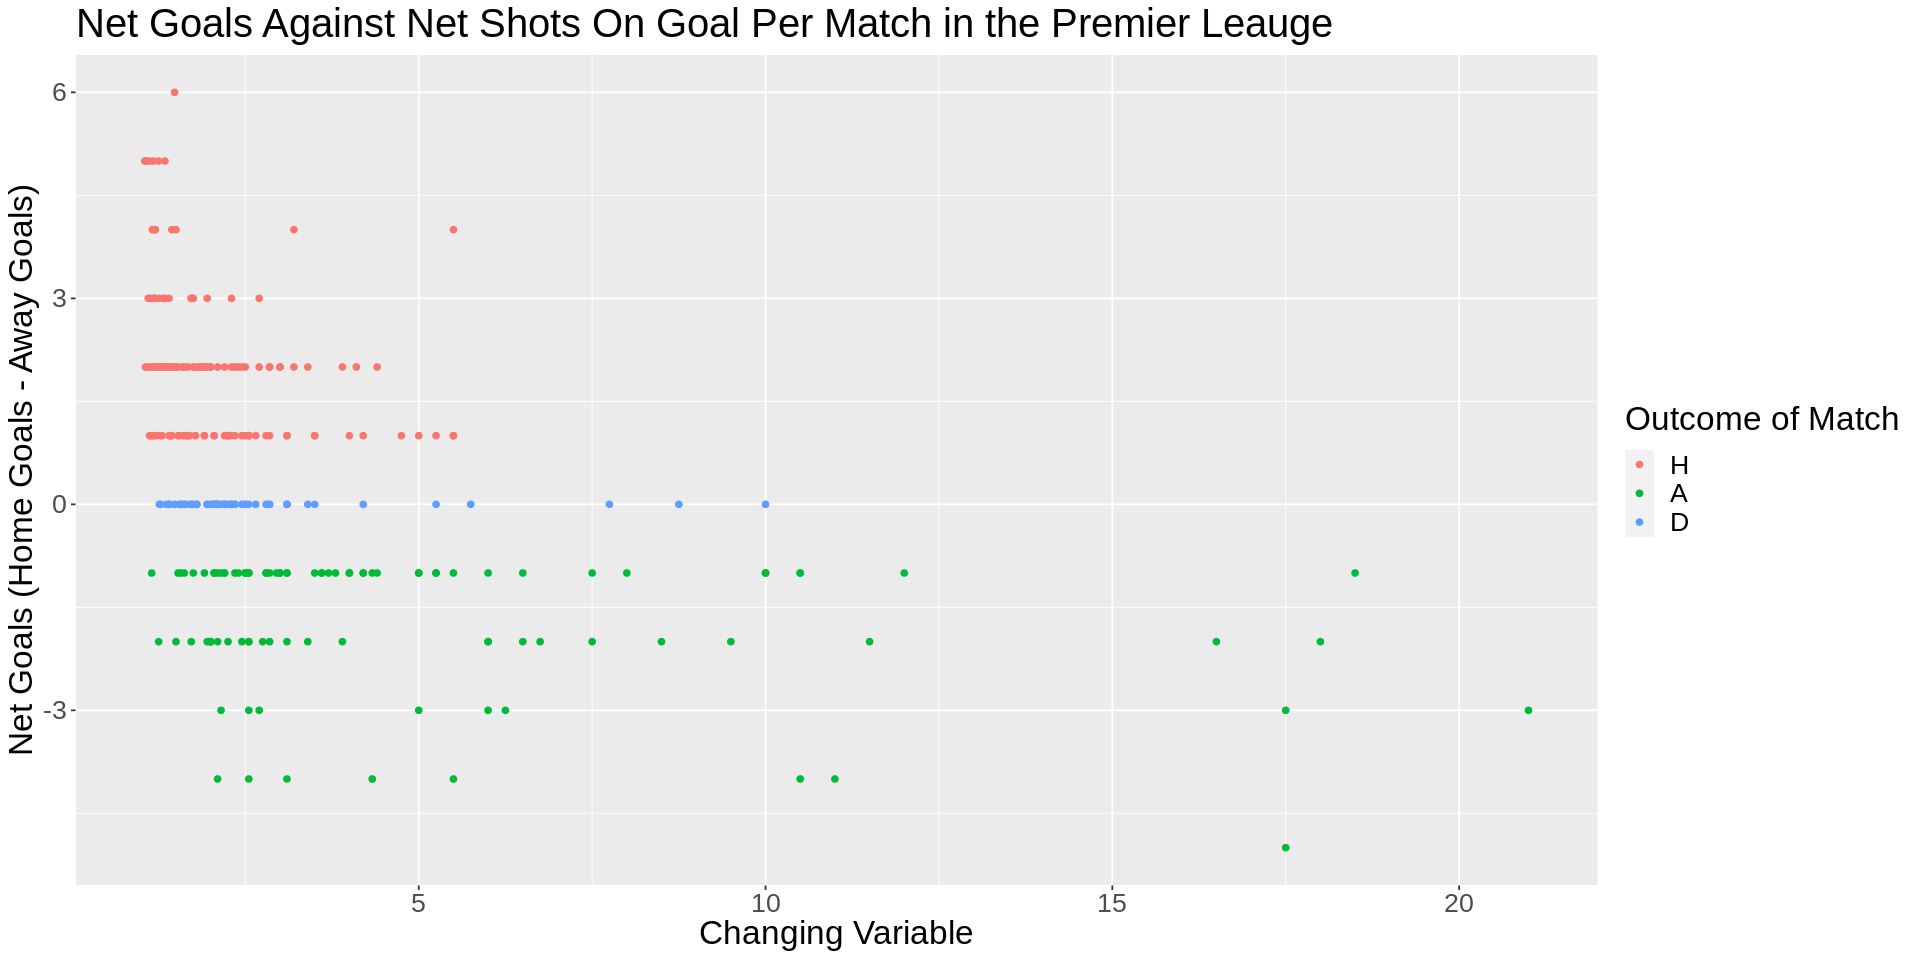

In [12]:
options(repr.plot.height = 8, repr.plot.width = 16)

netscore_vs_netshots_plot <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShots = HS - AS) %>% 
    ggplot(aes(x= NetShots, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Net Shots (Home Shots - Away Shots)", y = "Net Goals (Home Goals - Away Goals)", 
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots Per Match in the Premier Leauge") +
    theme(text = element_text(size=20))

netscore_vs_netshots_ongoal_plot <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShotsOnGoal = HST - AST) %>% 
    ggplot(aes(x= NetShotsOnGoal, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Net Shots on Target (Home Shots on Target - Away Shots on Target)", 
         y = "Net Goals (Home Goals - Away Goals)",
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots On Goal Per Match in the Premier Leauge") +
    theme(text = element_text(size=20))

plot_1 <- match_train %>% 
    mutate(NetScore = FTHG - FTAG, NetShotsOnGoal = HST - AST) %>% 
    ggplot(aes(x= BWH, y = NetScore, color = FTR)) +
    geom_point() +
    labs(x= "Changing Variable", 
         y = "Net Goals (Home Goals - Away Goals)",
        color = "Outcome of Match") +
    ggtitle("Net Goals Against Net Shots On Goal Per Match in the Premier Leauge") +
    theme(text = element_text(size=20))

plot_1
#netscore_vs_netshots_plot
#netscore_vs_netshots_ongoal_plot

#### Note that:  H = Home Team Win | D = Draw/Tie | A = Away Team Win

#### Introduction
Betting on the outcomes of soccer matches is very common in the sporting community. Based on our dataset, which team is more 
likely to win and what is the given score? This project involves using halftime match statistics to predict the outcome of the 
match, as well as the final score. The given dataset provides specific match information from the 2018-2019 Premier League games
including which teams played, half-time score, shots, shots-on-target, shots that hit woodwork, corner kicks, fouls committed, 
free kicks committed, yellow and red cards given out and more factors affecting the likeliness of a goal. 


#### Method:
We plan on using the following factors to conduct our data analysis:
Chosen Variables/Columns| Justification: 

FTHG and HG = Full Time Home Team Goals
Testing Data: Not used in our predictions
FTAG and AG = Full Time Away Team Goals
Testing Data: Not used in our predictions
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
Testing Data: Not used in our predictions
HTHG = Half Time Home Team Goals
Allows for performance assessment at half time when paired with total attempted team shots.
HTAG = Half Time Away Team Goals


HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)


HS = Home Team Shots
Combined with total team goals, total team shots allow us to further predict the accuracy of the team at halftime.
AS = Away Team Shots


HST = Home Team Shots on Target
(Shot blocked by opponent’s goalie)
This factor pair gives us an idea of how many times a team got close to the opponent’s net and the effectiveness of their 
opponent’s goalie.
AST = Away Team Shots on Target
(Shot blocked by opponent’s goalie)


HHW = Home Team Hit Woodwork
Alongside HST and AST, these factors show us how many times a team got within shooting distance of the net.
AHW = Away Team Hit Woodwork


HC = Home Team Corners
Shows a team’s accuracy and how often the team reaches the opponent’s goal.
AC = Away Team Corners


HFKC = Home Team Free Kicks Conceded


AFKC = Away Team Free Kicks Conceded


HO = Home Team Offsides
Frequency of fouls and how often the team is around the opponent’s goal
AO = Away Team Offsides




In our data analysis, we plan on visualizing our data using a scatter plot. Using a scatter plot will allow us to better 
understand the correlation between predictors (see list of columns and variables above) and net goal difference.


#### Expected outcomes and significance
In our data analysis, we expect to successfully and accurately find the winner between two teams, alongside the final score. 
These findings could increase the probability of an accurate prediction regarding the outcome of a game between two teams. Our 
analysis can then be used to answer future questions, such as : Which team in a league has the greatest chances of winning for 
the given season?


In [13]:
match_train <- mutate(match_train, NetScore = FTHG - FTAG)
match_test <- mutate(match_test, NetScore = FTHG - FTAG)

In [29]:
set.seed(1234)
# match_data
# match_split <- initial_split(match_data, prop = 3/4, strata = "FTR")  
# match_train <- training(match_split)   
# match_test <- testing(match_split)
#HTHG + HTAG + HS + AS + HST + HC + AC + HY + AY+ HR + AR + B365H + B365A+ BWH + BWA
match_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("regression") 

match_recipe_home <- recipe(NetScore ~ HTHG+HTAG+HS+AS+HST+AST+#HF+AF+HC+AC++HY+AY+HR+AR+
                            B365H+B365D+B365A+BWH+BWD+BWA+IWH+IWD+IWA, data = match_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

match_vfold <- vfold_cv(match_train, v=5, strata = NetScore)

match_workflow <- workflow() %>% 
    add_recipe(match_recipe_home) %>% 
    add_model(match_spec)


gridvals <- tibble(neighbors = seq(from = 1, to = 200))

match_results <- match_workflow %>% 
        tune_grid(resamples = match_vfold, grid = gridvals) %>% 
        collect_metrics()

match_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.5906341,5,0.02059554,Model001
1,rsq,standard,0.4201106,5,0.02379212,Model001
2,rmse,standard,1.3343866,5,0.05361543,Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rsq,standard,0.4260177,5,0.01984774,Model199
200,rmse,standard,1.7874736,5,0.03545956,Model200
200,rsq,standard,0.4163638,5,0.02218763,Model200


In [30]:
match_min <- match_results %>%
   filter(.metric == "rmse") %>%
   arrange(mean) %>% 
   slice(1)

match_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,1.218101,5,0.04215022,Model007


In [31]:
set.seed(1234)

k_min <- match_min %>%
         pull(neighbors)

match_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

match_best_fit <- workflow() %>%
         add_recipe(match_recipe_home) %>%
         add_model(match_best_spec) %>%
         fit(data = match_train)

match_summary <- match_best_fit %>%
          predict(match_test) %>%
          bind_cols(match_test) %>%
          metrics(truth = NetScore, estimate = .pred)

match_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.4088302
rsq,standard,0.5128409
mae,standard,1.1306991


In [35]:
set.seed(2019)

options(repr.plot.width = 7, repr.plot.height = 7)

match_preds <- match_best_fit %>% 
        predict(match_train) %>% 
        bind_cols(match_train) %>% 
        mutate(.pred = as.integer(round(.pred)))
        

match_preds

print(match_preds, n=40)

# match_plot <- match_train %>% 
#         ggplot(aes(x= NetScore, y= NetScore)) +
#         geom_point(alpha=0.5) +
#         geom_line(data = match_preds,
#                  mapping = aes(x = NetScore, y= .pred),
#                  color = "blue") + 
#         xlab("Half Time Goals")+
#         ylab("Full Times Goals") +
#         ggtitle("Cool Title bRo") 

# match_plot

.pred,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,⋯,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,NetScore
<int>,<chr>,<chr>,<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
-2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,⋯,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90,-2
-2,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,⋯,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58,-3
-1,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,⋯,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89,-1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,E0,12/05/2019,Man United,Cardiff,0,2,A,0,1,⋯,21,-2.0,2.52,2.32,1.72,1.64,1.30,6.06,9.71,-2
0,E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,⋯,19,-0.5,2.13,2.08,1.85,1.80,1.91,3.81,4.15,0
-1,E0,12/05/2019,Watford,West Ham,1,4,A,0,2,⋯,19,-0.5,2.25,2.19,1.78,1.72,2.11,3.86,3.41,-3


# A tibble: 286 x 64
   .pred Div   Date  HomeTeam AwayTeam  FTHG  FTAG FTR    HTHG  HTAG HTR  
   <int> <chr> <chr> <fct>    <fct>    <int> <int> <fct> <dbl> <dbl> <chr>
 1    -2 E0    11/0… Fulham   Crystal…     0     2 A         0     1 A    
 2    -2 E0    11/0… Hudders… Chelsea      0     3 A         0     2 A    
 3    -1 E0    11/0… Newcast… Tottenh…     1     2 A         1     2 A    
 4     1 E0    11/0… Watford  Brighton     2     0 H         1     0 H    
 5    -1 E0    12/0… Arsenal  Man City     0     2 A         0     1 A    
 6     3 E0    12/0… Liverpo… West Ham     4     0 H         2     0 H    
 7     0 E0    12/0… Southam… Burnley      0     0 D         0     0 D    
 8     1 E0    18/0… Chelsea  Arsenal      3     2 H         2     2 D    
 9     1 E0    18/0… Leicest… Wolves       2     0 H         2     0 H    
10     1 E0    18/0… Tottenh… Fulham       3     1 H         1     0 H    
11     0 E0    18/0… West Ham Bournem…     1     2 A         1     0 H    
12  

In [ ]:
plot_thing <- match_test %>% 
                select(-Date, -HomeTeam, -AwayTeam, -Referee) %>% 
                ggpairs(match_test)
plot_thing

Warning message:
“Ignoring unknown aesthetics: Div, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HTHG, HTAG, HTR, Referee, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, PSH, PSD, PSA, WHH, WHD, WHA, VCH, VCD, VCA, Bb1X2, BbMxH, BbAvH, BbMxD, BbAvD, BbMxA, BbAvA, BbOU, BbMx>2.5, BbAv>2.5, BbMx<2.5, BbAv<2.5, BbAH, BbAHh, BbMxAHH, BbAvAHH, BbMxAHA, BbAvAHA, PSCH, PSCD, PSCA”
Warning message:
“Ignoring unknown aesthetics: Div, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HTHG, HTAG, HTR, Referee, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, PSH, PSD, PSA, WHH, WHD, WHA, VCH, VCD, VCA, Bb1X2, BbMxH, BbAvH, BbMxD, BbAvD, BbMxA, BbAvA, BbOU, BbMx>2.5, BbAv>2.5, BbMx<2.5, BbAv<2.5, BbAH, BbAHh, BbMxAHH, BbAvAHH, BbMxAHA, BbAvAHA, PSCH, PSCD, PSCA”
Warning message:
“Ignoring unknown aesthetics: Div, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HTHG, HTAG, HTR, Referee, HS, AS, HST, AST, HF,